#Comparing and evaluating models


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

##An example of a classifier

In [8]:
df=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [9]:
from sklearn.linear_model import LogisticRegression

In [11]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [14]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, df, ['Weight', 'Height'],'Gender','Male', mask=mask)

using mask
BEST {'C': 0.01} 0.918285714286 [mean: 0.91829, std: 0.00569, params: {'C': 0.01}, mean: 0.91829, std: 0.00569, params: {'C': 0.1}, mean: 0.91829, std: 0.00569, params: {'C': 1}, mean: 0.91829, std: 0.00569, params: {'C': 10}, mean: 0.91829, std: 0.00569, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.92
[[1423  114]
 [ 121 1342]]
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


##The confusion matrix

In [15]:
confusion_matrix(ytest_l, clf_l.predict(Xtest_l))

array([[1423,  114],
       [ 121, 1342]])

We have written a classifier. This classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](https://dl.dropboxusercontent.com/u/75194/images/bookimages/confusionmatrix.png)

Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

However, in a case like that of the cancer classifier, we will wish to minimize false nagatives at the expense of false positives: it is ok to send perfectly healthy patients for cancer folloup if that is the price we must pay for not missing any sick ones.

`scikit-learn` helpfully gives us a classification report with all these numbers

In [16]:
from sklearn.metrics import classification_report
print classification_report(ytest_l, clf_l.predict(Xtest_l))

             precision    recall  f1-score   support

          0       0.92      0.93      0.92      1537
          1       0.92      0.92      0.92      1463

avg / total       0.92      0.92      0.92      3000



##The churn example

In [20]:
#data set from yhathq: http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html
dfchurn=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/churn.csv")
dfchurn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [21]:
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

In [22]:
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'

In [23]:
colswewant_cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
colswewant_cat=[u"Int'l Plan", u'VMail Plan']

![m:abmodeldiag](https://dl.dropboxusercontent.com/u/75194/images/extimages/abmodeldiag.png)

A has large FP, B has large FN. On asymmetric, using accuracy, A will do very bad. But is accuracy the right thing to do?

##Changing the Prediction threshold

However, is this the real question of importance? Our dataset is a very lopsided data set with 84% of samples being negative. In such a case, accuracy is not a very good measure of a classifier.

Also notice that, as is often the case in situations in which one class dominates the other, the costs of one kind of misclassification: false negatives are differently expensive than false positives. We saw above that FN are more costly in our case than FP. Similar situations arise in cancer prediction, for example, where a FP only means that you diagnosed a healthy person with cancer, but a FN means that you misdiagnosed a cancer patient as healthy: possibly killing them in the process!

In the case of such asymmetric costs, the `sklearn` API function `predict` is useless, as it assumes a threshold probability of having a +ive sample to be 0.5; that is, if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN are more expensive than FP, you want to lower this threshold: you are ok with falsely classifying -ive examples as +ive. We play with this below by chosing a threshold `t` in the function `t_repredict` which chooses a different threshold than 0.5 to make a classification.

One caveat: we cannot repredict for the linear SVM model `clfsvm`, as the SVM is whats called a "discriminative" classifier: it directly gives us a decision function, with no probabilistic explanation and no probabilities. (I lie, an SVM can be retrofitted with probabilities: see http://scikit-learn.org/stable/modules/svm.html#scores-probabilities, but these are expensive amd not always well callibrated).

Cleary then, accuracy will not remain good metric, as you will "accept" many more false negatives in favor of false positives. What metric should one use then? One metric is very obvious: we can just choose the average profit per person.

In [24]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [25]:
confusion_matrix(ytest_l, repredict(clf_l, 0.1, Xtest_l))

array([[1102,  435],
       [  22, 1441]])

##The ROC Curve

ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. (In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5).

The way ROC curves are calulated is this. We start with a large threshold, something like 0.99 or so, such that no sample is classified as +ive, We then decrease (or keep same) this threshold by going one sample at a time. At first, only the most likely samples become positive. Thus, as we keep decreasing the threshold, the true positives rise faster than the false positives. Once past a certain point, false positives increase faster than true positives. Thus, if you want a balanced classifier, you look at this turn-around point...the northwest corner, so to speak. This may or may not happen at 0.5 depending on the dataset and classifier. 


![m:roc curve](https://dl.dropboxusercontent.com/u/75194/images/extimages/roc-curve.png)

![howto roc](https://dl.dropboxusercontent.com/u/75194/images/extimages/howtoroc.png)

In [17]:
from sklearn.metrics import roc_curve, auc

We provide example code `make_roc` for you to calculate a ROC curve.  

In [18]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

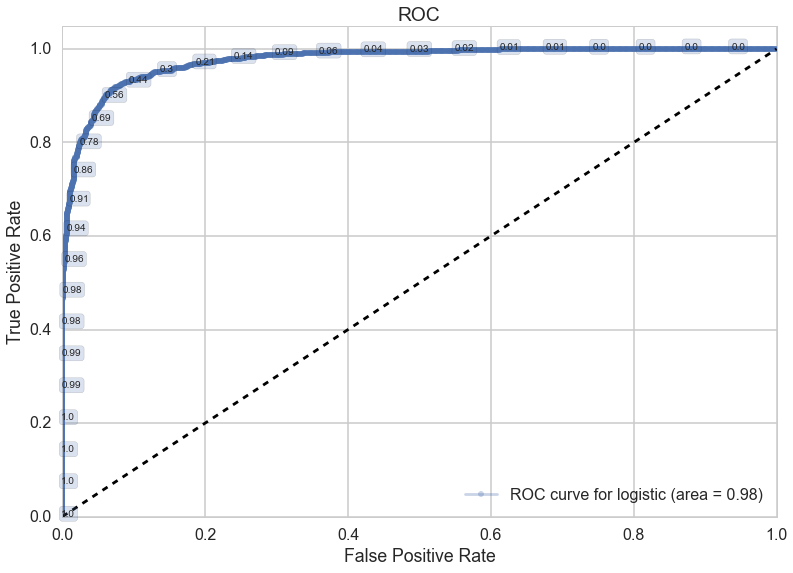

In [19]:
make_roc("logistic", clf_l, ytest_l, Xtest_l, labe=100)

##Back to Churn: Making a profit

In [26]:
churntrain, churntest = train_test_split(xrange(dfchurn.shape[0]), train_size=0.6)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

array([False,  True, False, ...,  True,  True,  True], dtype=bool)

####Establishing Baseline Classifiers via profit or loss.

Whenever you are comparing classifiers you should always establish a baseline, one way or the other.  In our churn dataset there are two obvious baselines: assume every customer wont churn, and assume all customers will churn.

The former baseline, will on our dataset, straight away give you a 85.5% accuracy. If you are planning on using accuracy, any classifier you write ought to beat this. The other baseline, from an accuracy perspective is less interesting: it would only have a 14.5% correct rate.

But as we have seen, on such asymmetric data sets, accuracy is just not a good metric. So what should we use.

**A metric ought to hew to the business function that the classifier is intended for**.

In our case, we want to minimize the cost/maximize the profit for the telecom.

But to do this we need to understand the business situation. To do this, we write a **utility**, or, equivalently, **cost** matrix associated with the 4 scenarios that the confusion matrix talks about.

Remember that +ives are churners. 

Lets assume we make an offer with an administrative cost of \$3 and an offer cost of \$100, an incentive for the customer to stay with us. If a customer leaves us, we lose the customer lifetime value, which is some kind of measure of the lost profit from that customer. Lets assume this is the average number of months a customer stays with the telecom times the net revenue from the customer per month. We'll assume 3 years and \$30/month margin per user lost, for roughly a $1000 loss.

In [50]:
admin_cost=3
offer_cost=100
clv=1000

- TN=people we predicted not to churn who wont churn. We associate no profit with this as they continue being our customers
- FP=people we predict to churn. Who wont. Lets associate a `admin_cost+offer_cost` cost per customer with this as we will spend some money on getting them not to churn, but we will lose this money.
- FN=people we predict wont churn. And we send them nothing. But they will. This is the big loss, the `clv`
- TP= people who we predict will churn. And they will. These are the people we can do something with. So we make them an offer. Say a fraction f accept it. Our cost is

`f * offer_cost + (1-f)*(clv+admin_cost)`

This model can definitely be made more complex.

Lets assume a conversion fraction of 0.5

In [51]:
conv=0.5
cost=np.array([[0.,admin_cost+offer_cost],[clv, conv*offer_cost + (1. - conv)*(clv+admin_cost)]])
print cost

[[    0.    103. ]
 [ 1000.    551.5]]


In [76]:
costfn=cost[1][0]
costfp=cost[0][1]

We can compute the average cost(profit) per person using the following formula, which calculates the "expected value" of the per-customer loss/cost(profit):

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& \frac{TP \times c(1P,1A) + FP \times c(1P,0A) + FN \times c(0P,1A) + TN \times c(0P,0A)}{N}
\end{eqnarray}

where N is the total size of the test set, 1P is predictions for class 1, or positives, 0A is actual values of the negative class in the test set. The cost/profit can thus be found by multiplying the loss/utility matrix by the confusion matrix elementwise, and dividing by the sum of the elements in the confusion matrix, or the test size.

We implement this process of finding the average cost per person in the `average_cost` function below:

In [52]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

####No customer churns and we send nothing

In [61]:
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

In [62]:
testsize = dfchurn[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(testchurners, ypred_dste)

[[1160    0]
 [ 174    0]]


In [64]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

130.43478260869566

####All customers churn, we send everyone

In [65]:
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(testchurners, ypred_ste)

[[   0 1160]
 [   0  174]]


In [66]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

161.5

The first one is the one to beat!

## Back to Churn: Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", mask=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.87
[[1072   88]
 [  84   90]]
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [68]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1072,   88],
       [  84,   90]])

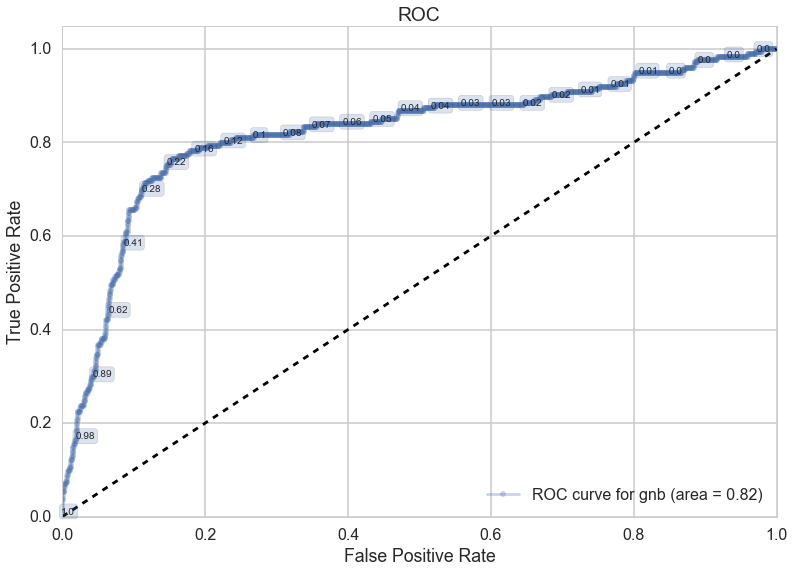

In [69]:
make_roc("gnb",clfgnb, ytest, Xtest, None, labe=50)

##Classifier Comparison

![m:roc space](https://dl.dropboxusercontent.com/u/75194/images/extimages/ROCspace.png)

We can compare the models using the ROC curves. 

ROC curves are useful because they calculate one classifier per threshold and show you where you are in TPR/FPR space without making any assumptions about the utility matrix or which threshold is appropriate.

By the same token, a rote reading of the ROC curve (go to the "northwest" corner) is a bad idea: you must fold in the curve with any assumptions you are making about the utilities. In our case we have both an asymmetric data set, and asymmetric risk, so the north west corner may not be the right spot. Still, on the whole, a curve with a greater AUC (area under curve), or further away from the line of randomness, will give us a rough idea of what might be a better classifier.

ROC curves have an advantage for discriminative classifiers like the SVM. Such classifiers give us a `decision_function` which basically captures the distance of a sample from the dividing line. Negative distances correspond to negative samples, positive ones to positive sample. In other words, the SVM provides us with a set of **ranked** scores. This is all we need to make a ROC curve: we move instead from the max-rank to the min-rank, and our thresholds are scores instead. Pass `proba=False` to `make_roc` for this.

###Decision Trees

Descision trees are very simple things we are all familiar with. If a problem is multi-dimensional, the tree goes dimension by dimension and makes cuts in the space to create a classifier.

From scikit-docs:
    
http://scikit-learn.org/stable/_images/iris.svg

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [72]:
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, {"max_depth": range(1,10,1)}, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", reuse_split=reuse_split)

using reuse split
BEST {'max_depth': 6} 0.927963981991 [mean: 0.84992, std: 0.01346, params: {'max_depth': 1}, mean: 0.86843, std: 0.01030, params: {'max_depth': 2}, mean: 0.89595, std: 0.00459, params: {'max_depth': 3}, mean: 0.90695, std: 0.00784, params: {'max_depth': 4}, mean: 0.92646, std: 0.00903, params: {'max_depth': 5}, mean: 0.92796, std: 0.01112, params: {'max_depth': 6}, mean: 0.92696, std: 0.01041, params: {'max_depth': 7}, mean: 0.92196, std: 0.00916, params: {'max_depth': 8}, mean: 0.91846, std: 0.00666, params: {'max_depth': 9}]
############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.94
[[1131   29]
 [  52  122]]
########################################################


In [73]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1131,   29],
       [  52,  122]])

###Compare!

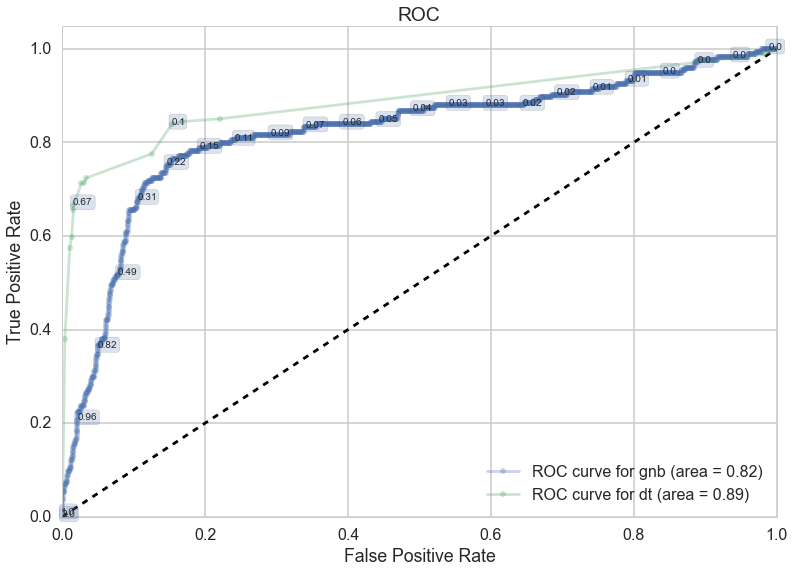

In [38]:
ax=make_roc("gnb",clfgnb, ytest, Xtest, None, labe=60)
make_roc("dt",clfdt, ytest, Xtest, ax, labe=5)

##Reprediction again

You can use the utility or risk matrix to provide a rough threshold to pick for now for our classifier. (You will implement a more powerful method next). The idea is that we want to maximize utility or profit, so for each sample, simply pick the class which does that. 

Say we make a "decision g about which class" at a sample x. Then:

$$R_g(x) = l(1, g)p(1|x) + l(0, g)p(0|x).$$

Then for the "decision" $g=1$ we have:

$$R_1(x) = l(1,1)p(1|x) + l(0,1)p(0|x),$$

and for the "decision" $g=0$ we have:

$$R_0(x) = l(1,0)p(1|x) + l(0,0)p(0|x).$$

Now, we'd choose $1$ for the sample at $x$ if:

$$R_1(x) \lt R_0(x).$$

$$ P(1|x)(l(1,1) - l(1,0)) \lt p(0|x)(l(0,0) - l(0,1))$$

This gives us a ratio `r` between the probabilities to make a prediction. We assume this is true for all samples.

So, to choose '1':

$$p(1|x) \gt r P(0|x) \implies r=\frac{l(0,1) - l(0,0)}{l(1,0) - l(1,1)} =\frac{c_{FP} - c_{TN}}{c_{FN} - c_{TP}}$$

This may also be written as:

$$P(1|x) \gt t = \frac{r}{1+r}$$.

For the purely asymmetric case:

$$r = \frac{l_{FP}}{l_{FN}}$$

Unbalanced classes typically act in the same direction and suppress the effect.

In [78]:
cost

array([[    0. ,   103. ],
       [ 1000. ,   551.5]])

In [79]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [80]:
def c_repredict(est, c, xtest):
    r = rat(c)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (r*p0 < p1)*1
    return ypred

##Model selection from Cost and ROC

Lets rewrite the cost equation from before.

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& p(1A) \times \left ( c(1P,1A) \times p(1P | 1A) + c(0P,1A) \times p(0P | 1A) \right ) \\
&+& p(0A) \times \left ( c(1P,0A) \times p(1P,0A) + c(0P,0A) \times p(0P | 0A) \right ) \\
&=& p(1A) \times \left ( c(1P,1A) \times TPR + c(0P,1A) \times (1 - TPR)\right ) \\
&+& p(0A) \times \left ( c(1P,0A) \times FPR + c(0P,0A) \times (1 - FPR) \right )
\end{eqnarray}


This can then be used to write TPR in terms of FPR, which as you can see is a line for fixed cost. So lines on the graph correspond to a fixed cost. If-course they must intersect the ROC curve to be acceptable as coming from our classifier.

$$TPR = \frac{1}{p(1A)(c_{FN} - c_{TP})} \left ( p(1A) c_{FP} + p(0A) c_{TN} - Cost \right ) + r \frac{p(0A)}{p(1A)} \times FPR$$

There are three observations to be made from here.

1. The slope is the reprediction ratio $r$ multiplied by the negative positive imbalance. In the purely asymmetric case the ratio r is the ratio of the false-positive cost to the false-negative cost. Thus for the balanced case, low slopes penalize flase negatives and correspond to low thresholds
2. When imbalance is included, a much more middling slope is achieved, since low $r$ usually comes with high negative-positive imbalance. So we still usually land up finding a model somewhere in the northwest quadrant.
3. The line you want is a tangent line. Why? The tangent line has the highest intercept.

The lowest cost model corresponds to the re-prediction model which minimized the cost on a per sample basis.

For balanced classes:
![asyroc](https://dl.dropboxusercontent.com/u/75194/images/bookimages/asyroc.png)

##Cost curves

The proof is always in the pudding. So far we have used a method to calculate a rough threshold from the cost/utility matrix, and seen the ROC curve which implements one classifier per threshold to pick an appropriate model. But why not just plot the cost/profit (per person) per threshold on a ROC like curve to see which classifier maximizes profit/minimizes cost? 

Thus, what we do again is to use the probabilities (or scores) output by our model to "rank" the samples in our test set from those most likely to be +ive to those least likely to be positive. For example, as sample with probability 0.9 of being positive is more likely to be positive than one with probability 0.4. This is a statement thats independent of our threshold for classification.

Then, just like in a ROC curve, we go down this sorted list of samples. We one-by-one add an additional sample to our positive samples, noting down the threshold, and its attendant classifier's TPR and FPR. In addition to what we do for the ROC curve, we also note  down the percentage of our list of samples predicted as positive. Finally at each such additional sample, we calculate the expected cost/profit per person and plot it against the percentage to produce a cost/profit curve. Thus, small percentages correspond to samples most likely to be positive.

As in the ROC curve case, we use `sklearn`'s `roc_curve` function to return us a set of thresholds with TPRs and FPRs.

In [84]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

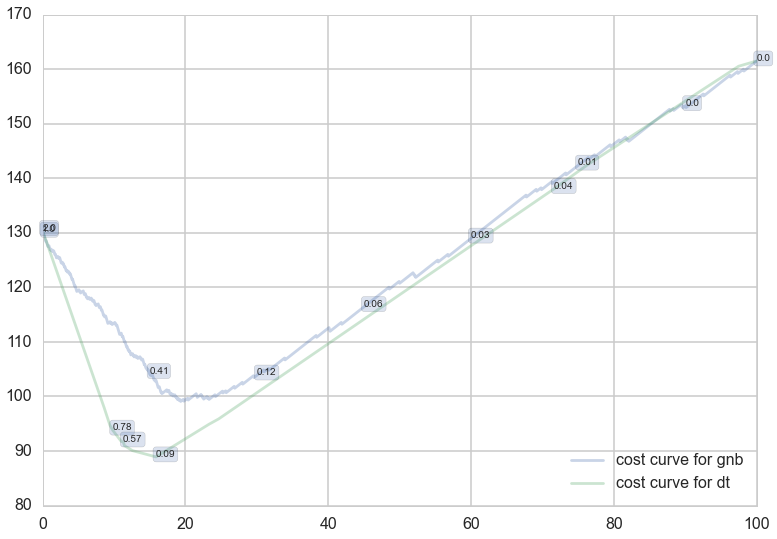

In [95]:
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True);
plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=3);

NOTE the ones on left are most likely to churn (be positive).

This if you had a finite budget, you should be targeting them!

##Ensemble Classifiers: Decision Trees and Random Forests

We use it to create a random forest from a set of trees. We do two things:

* **Bagging** : here we create a bootstrap sample with replacement and we run on this sample
* We choose random subsets of the features for each tree

From Johnson, Shape of Data blog:

![random forest](https://dl.dropboxusercontent.com/u/75194/images/extimages/randforest.png)

When we do this we get trees lke the ones seen in the diagram above. What we do now, is that for each region of the space (on some suitable grid) we find out what result each tree gives us. Then we go majority vote, like in kNN. This process of resampling and averaging over the trees reduces the overfitting a bit.
For two features the second dosent make a huge amount of sense, but lets see it as we can see that the overfitting is softened a bit by the averaging:

In [86]:
def classify_tree(clf, Xtrain, Xtest, ytrain, ytest):
#     subdf=indf[inacidlist]
#     subdfstd=(subdf - subdf.mean())/subdf.std()
#     X=subdfstd.values
#     y=(indf[clon].values==clonval)*1
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

In [87]:
from sklearn.ensemble import RandomForestClassifier
clfrf=RandomForestClassifier(n_estimators=100)
clfrf, Xtrain, ytrain, Xtest, ytest=classify_tree(clfrf, Xtrain, Xtest, ytrain, ytest)

Accuracy on training data: 1.00
Accuracy on test data:     0.96


In [88]:
confusion_matrix(ytest, clfrf.predict(Xtest))

array([[1147,   13],
       [  44,  130]])

##FIN

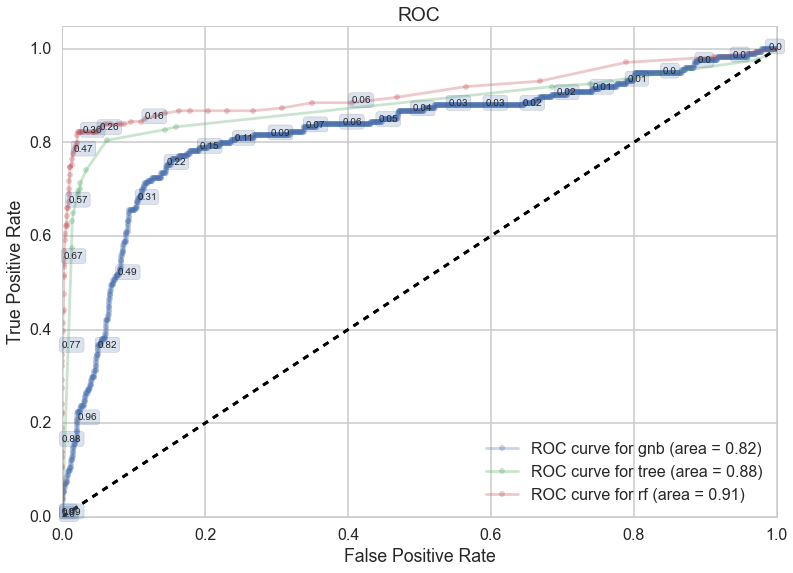

In [89]:
ax=make_roc("gnb",clfgnb, ytest, Xtest, None, labe=60)
ax=make_roc("tree",clfdt, ytest, Xtest, None, labe=60)
make_roc("rf",clfrf, ytest, Xtest, ax, labe=10);

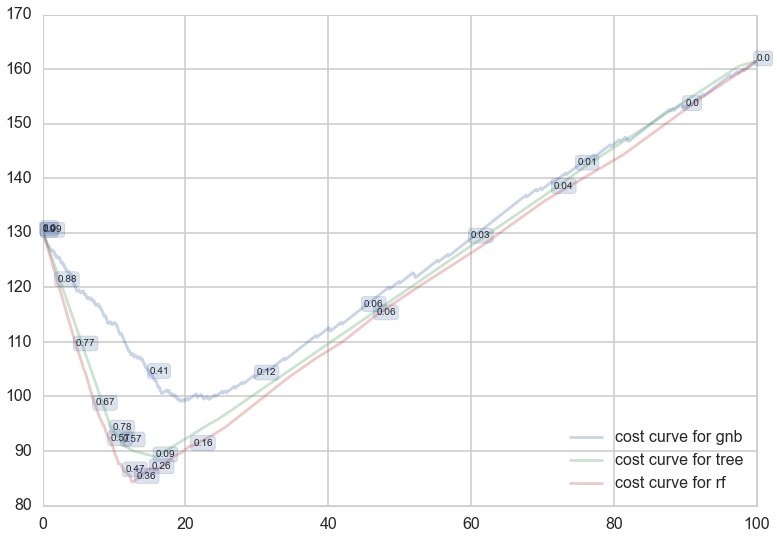

In [97]:
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True);
plot_cost("tree",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=3);
plot_cost("rf",clfrf, ytest, Xtest, cost, ax, threshold=True, labe=10);